In [1]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
import matplotlib.pyplot as plt

import warnings
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler

## charger les données

In [2]:
data = pd.read_csv("../data/preprocess_table.csv")

## classe déséquilibrée

In [3]:
# Séparer les caractéristiques (X) et les étiquettes (y)
X = data.drop(columns=['TARGET'])
y = data['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0.0: 282682, 1.0: 24825})


In [4]:
X.shape

(307507, 776)

### traitement des données

In [5]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [7]:
# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
counter = Counter(y_train)
print(counter)



Counter({0.0: 226145, 1.0: 19860})


## configurer ML_flow

In [9]:
#définition du serveur de suivi mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")  #équivalent à http://localhost:5000
# le lancer sur un prompt : mlflow server --host 127.0.0.1 --port 5000

### score

In [10]:
# Définir la fonction de coût
def cost_function(y_true, y_pred_prob, threshold, cost_fn=10, cost_fp=1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fn * cost_fn) + (fp * cost_fp)
    return cost

In [11]:
experiment_name="P7_EJ_score"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/885410989458547713', creation_time=1744652016843, experiment_id='885410989458547713', last_update_time=1744652016843, lifecycle_stage='active', name='P7_EJ_score', tags={}>

## baseline

### régression logistique

In [12]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "Logistic Regression")

    # Initialiser et entraîner le modèle
    model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)

    # Enregistrer les métriques
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LR_simple_déséquilibré")

Registered model 'LR_simple_déséquilibré' already exists. Creating a new version of this model...
2025/05/05 16:36:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LR_simple_déséquilibré, version 2


🏃 View run zealous-robin-873 at: http://127.0.0.1:5000/#/experiments/885410989458547713/runs/04ba88df5a0f482aa1757de7bb0d91cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/885410989458547713


Created version '2' of model 'LR_simple_déséquilibré'.


### utilisation du score cost

In [13]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "Logistic Regression")

    # Initialiser et entraîner le modèle
    model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)

    # Enregistrer les métriques
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LR_cost_déséquilibré")

Registered model 'LR_cost_déséquilibré' already exists. Creating a new version of this model...
2025/05/05 16:37:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LR_cost_déséquilibré, version 2


🏃 View run melodic-rook-437 at: http://127.0.0.1:5000/#/experiments/885410989458547713/runs/807da57c25eb4d178740951174ceeb29
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/885410989458547713


Created version '2' of model 'LR_cost_déséquilibré'.


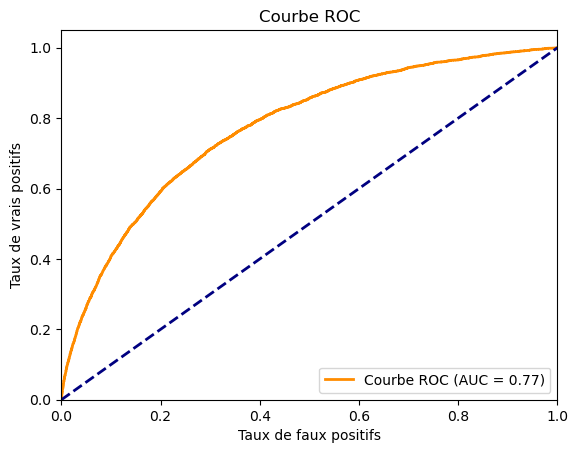

In [14]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### optimisation hyperparamètres sur échantillon

gridsearchCV et randomsearchCV plante faute de mémoire
on va donc chercher à optimiser les hyperparamètres sur un éhcantillon

In [15]:
X_train.shape, y_train.shape

((246005, 776), (246005,))

### recherche hyperparamètre LR sur échantillon

In [16]:
# Sous-échantillonnage des données
sample_size = 10000  # Taille de l'échantillon
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, stratify=y_train, random_state=42)

# Séparer les données échantillonnées en ensembles d'entraînement et de test
X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [17]:
# Réduire la précision des données
X_samp_train = X_samp_train.astype(np.float32)
X_samp_test = X_samp_test.astype(np.float32)

In [18]:
# Vérifier qu'il n'y a pas de valeurs manquantes dans X_train
assert not np.isnan(X_train).any(), "Il y a des valeurs manquantes dans X_train après l'imputation."

In [19]:
# Définir une grille d'hyperparamètres
param_dist = {
    'C': [ 0.1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # 'liblinear' supporte à la fois 'l1' et 'l2'
    'class_weight': [None, 'balanced']}

In [20]:
# Initialiser le modèle
model = LogisticRegression(random_state=42, class_weight='balanced')
# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)


In [21]:
# Effectuer la recherche d'hyperparamètres
random_search.fit(X_samp_train, y_samp_train)

# Enregistrer les meilleurs paramètres
best_params = random_search.best_params_
    

C:\Users\Emmanuel\anaconda3\envs\P7_py311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(

KeyboardInterrupt



In [ ]:
best_params

In [ ]:
random_search.best_estimator_

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres    
    mlflow.log_params(best_params)
   

    # Enregistrer les métriques
    best_model = random_search.best_estimator_
    y_pred_prob = best_model.predict_proba(X_samp_test)[:, 1]
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, best_model.predict_proba(X_train))
    mlflow.sklearn.log_model(best_model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LR_partiellement_optimisée_échantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## random forest sur échantillon

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "Random forest classifier")

    # Initialiser et entraîner le modèle
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_samp_train, y_samp_train)

    # Enregistrer les métriques
    y_pred_prob = model.predict_proba(X_samp_test)[:, 1]
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "RF_echantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### optimisation hyperparamètres sur échantillon

In [ ]:
# Initialiser le modèle
model = RandomForestClassifier(random_state=42)
# Définir les hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2,  10],
    'min_samples_leaf': [1, 3],
    'max_features': ['log2', 'sqrt'],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True, False]
}
# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)


In [ ]:
# Effectuer la recherche d'hyperparamètres
random_search.fit(X_samp_train, y_samp_train)

# Enregistrer les meilleurs paramètres
best_params = random_search.best_params_
    

In [ ]:
best_params

In [ ]:
random_search.best_estimator_

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "Random forest classifier")

    # Initialiser et entraîner le modèle
    best_model = random_search.best_estimator_
    best_model.fit(X_samp_train, y_samp_train)

    # Enregistrer les métriques
    y_pred_prob = best_model.predict_proba(X_samp_test)[:, 1]
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, best_model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "RF_optim_echantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## ligthGBM sur echantillon

In [ ]:
train_data = lgb.Dataset(X_samp_train, label=y_samp_train)
test_data = lgb.Dataset(X_samp_test, label=y_samp_test, reference=train_data)


In [ ]:
# Définir les paramètres et entraîner le modèle
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])



In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "LightGBM")

    
    # Prédire les probabilités
    y_pred_prob = gbm.predict(X_samp_test, num_iteration=gbm.best_iteration)
    # Calculer l'AUC
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_samp_train, gbm.predict(X_samp_train))
    mlflow.lightgbm.log_model(gbm, "LGBM", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LGBM_echantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### optimisation lgbm

In [ ]:
# Définir les hyperparamètres à tester
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 20],
    'min_child_samples': [5, 20],
    'subsample': [0.7,  0.9],
    'colsample_bytree': [0.7,  0.9],
    'reg_alpha': [ 0.1, 0.5],
    'reg_lambda': [ 0.1, 0.5],
    'class_weight': [None, 'balanced']
}
# Initialiser le modèle LightGBM
lgbm = lgb.LGBMClassifier()

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)




In [ ]:
# Exécuter la recherche
random_search.fit(X_samp_train, y_samp_train)

In [ ]:
# Enregistrer les meilleurs paramètres
best_params = random_search.best_params_

In [ ]:
best_params

In [ ]:
random_search.best_estimator_

In [ ]:
# Entraîner le modèle final avec les meilleurs paramètres

train_data = lgb.Dataset(X_samp_train, label=y_samp_train)
test_data = lgb.Dataset(X_samp_test, label=y_samp_test, reference=train_data)

gbm = lgb.train(best_params, train_data, num_boost_round=100, valid_sets=[test_data])

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    #  Enregistrer les paramètres du modèle
    mlflow.log_params(best_params)
    mlflow.log_param("model_type", "LightGBM")

    # Prédire les probabilités
    y_pred_prob = gbm.predict(X_samp_test, num_iteration=gbm.best_iteration)
    # Calculer l'AUC
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_samp_train, gbm.predict(X_samp_train))
    mlflow.lightgbm.log_model(gbm, "LGBM", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "LGBM_echantillon_optim")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## XGBoost sur échantillon

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "XGboost")

    # Initialiser et entraîner le modèle
    model = XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6,  scale_pos_weight=10)
    model.fit(X_samp_train, y_samp_train)

    # Enregistrer les métriques
    y_pred_prob = model.predict_proba(X_samp_test)[:, 1]
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "XGBoost_echantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### optimisation hyperparamètres sur échantillon

In [ ]:
# Définition du modèle
model = XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6,  scale_pos_weight=10)



In [ ]:
# Optimisation des hyperparamètres
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 10],
    'scale_pos_weight': [1, 10]
}

In [ ]:
random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)
random_search.fit(X_samp_train, y_samp_train)

In [ ]:
# Démarrer une run MLflow
with mlflow.start_run() as run:
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_type", "XGBoost")

    # Initialiser et entraîner le modèle
    best_model = random_search.best_estimator_
    best_model.fit(X_samp_train, y_samp_train)

    # Enregistrer les métriques
    y_pred_prob = best_model.predict_proba(X_samp_test)[:, 1]
    auc = roc_auc_score(y_samp_test, y_pred_prob)
    mlflow.log_metric("auc", auc)

    # Optimiser le seuil de décision
    thresholds = np.linspace(0, 1, 100)
    costs = [cost_function(y_samp_test, y_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(costs)]

    # Enregistrer le meilleur seuil
    mlflow.log_param("best_threshold", best_threshold)

    # Évaluer le modèle avec le meilleur seuil
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    min_cost = min(costs)
    mlflow.log_metric("min_cost", min_cost)

    # Enregistrer le modèle avec un exemple d'entrée pour la signature
    signature = mlflow.models.infer_signature(X_train, best_model.predict_proba(X_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # Enregistrer le modèle dans le Model Registry
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "XGBoost_optim_echantillon")

In [ ]:
# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_samp_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()